In [1]:
import sys; sys.path.append('../../')
import numpy as np
import pandas as pd
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.graphics.api as smg
from warnings import filterwarnings
from scipy import stats
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from analysis.constants import VOCAB_SIZE
from graphs.utils import plot_morris_method_graph
from analysis.utils import get_sa_problem
from SALib.sample.morris import sample
from SALib.analyze.morris import analyze
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

filterwarnings('ignore')

# Data Initialization

In [2]:
DATASET_PROPERTIES_PATH = r'..\..\results\dataset_properties.csv'
IMPURITY_DIFF_PATH = r'..\..\results\impurity_differences.csv'

In [3]:
dataset_properties_df = pd.read_csv(DATASET_PROPERTIES_PATH)
dataset_properties_df

,name,vocab_size,true_cluster_count,token_count_avg_entropy_a1,token_count_avg_entropy_a0,token_count_sum_entropy,token_count_flat_entropy,intra_cluster_spread,inter_cluster_spread,silhouette_score,calinski_harabasz_score,davies_bouldin_score
0,Android,524,166,1.150983,1.617744,4.953394,9.119025,0.071262,2.114244,0.940220,731.321987,0.470526
1,Apache,25,6,1.596729,4.931979,2.629490,9.243098,0.000000,1.694940,1.000000,1.000000,0.000000
2,BGL,712,120,1.110366,1.272794,5.166454,9.111435,0.260080,2.025537,0.839777,281.297632,0.454874
3,Hadoop,473,114,1.950064,1.270850,4.338157,9.630493,0.026865,2.588856,0.951416,4937.249012,0.399854
4,HDFS,44,14,1.639952,4.449821,3.257177,9.280811,0.062671,2.060039,0.969571,13900.899798,0.281032
5,HealthApp,192,75,0.530275,1.302377,3.538048,8.261430,0.000000,1.289976,0.984500,1.000000,0.000000
6,HPC,145,46,0.781811,2.244330,3.975028,8.734961,0.033661,1.588820,0.984047,1110.685184,0.683617
7,Linux,445,118,1.825927,0.996809,3.865464,9.463753,0.826279,1.924308,0.471962,67.252098,0.463806


In [4]:
impurity_differences_df = pd.read_csv(IMPURITY_DIFF_PATH)
impurity_differences_df.head()

,name,provided_labels_count,impurity_mean_diff,impurity_var_sum
0,Android,0,0.000000,0.001186
1,Android,100,0.025551,0.001277
2,Android,200,0.041785,0.001043
3,Android,300,0.065523,0.000786
4,Android,400,0.081771,0.001152


In [5]:
data_df = impurity_differences_df.merge(dataset_properties_df, on='name')
data_df = data_df.sample(frac=1)
X_df = data_df.drop(['name', 'impurity_mean_diff'], axis=1)
y_df = data_df[['impurity_mean_diff']]

# Data Plots

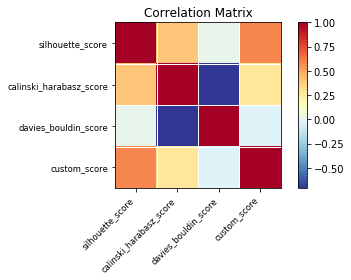

In [17]:
corr_scores_df = dataset_properties_df[['silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score']]
corr_scores_df['custom_score'] = (dataset_properties_df['inter_cluster_spread'] 
                                  / dataset_properties_df['intra_cluster_spread']).reset_index(drop=True)
corr_scores_df = corr_scores_df[corr_scores_df['custom_score'] != np.inf]

corr_scores_matrix = np.corrcoef(corr_scores_df.T)
smg.plot_corr(corr_scores_matrix, corr_scores_df.columns)
plt.show()

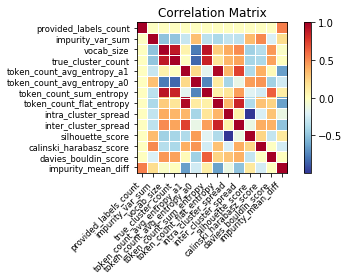

In [7]:
corr_df = pd.concat([X_df, y_df], axis=1).reset_index(drop=True)
corr_matrix_base = np.corrcoef(corr_df.T)
smg.plot_corr(corr_matrix_base, corr_df.columns)
plt.show()

# Sensitivity Analysis

In [8]:
X_train_dmatrix = xgb.DMatrix(X_df, y_df)

num_round = 50
param = {'max_depth':6, 'objective':'reg:squarederror' }
bst = xgb.train(param, X_train_dmatrix, num_round)

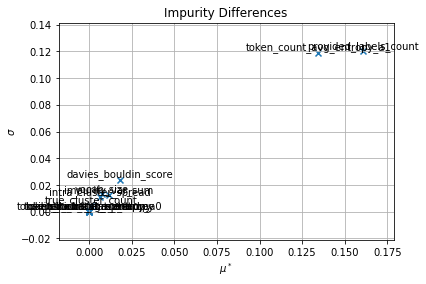

In [9]:
problem = get_sa_problem(X_df)
inputs = sample(problem, 1000, num_levels=4)

X_morris_df = pd.DataFrame(inputs, columns=X_df.columns)
X_morris_dmatrix = xgb.DMatrix(X_morris_df)
results = bst.predict(X_morris_dmatrix)

sensitivity_indices = \
    analyze(problem,
            inputs,
            results,
            conf_level=0.95,
            num_levels=5)

plot_morris_method_graph(sensitivity_indices, 'Impurity Differences')
plt.show()

In [10]:
bst_model = xgb.XGBRegressor(max_depth=6, num_round=50)
bst_scores = cross_val_score(bst_model, X_df, y_df, cv=10, scoring='neg_mean_squared_error')
bst_scores.mean()

-0.0006679362426553323

# Lasso

In [11]:
pipe = make_pipeline(StandardScaler(), Lasso())

param_dist = {'lasso__alpha': loguniform(1e-4, 2)}
random_search = RandomizedSearchCV(pipe, scoring = 'neg_mean_squared_error', 
                                   param_distributions=param_dist,
                                   n_iter=1000, cv=10, verbose=True)

random_search.fit(X_df, y_df)
random_search.best_params_

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:   45.0s finished


{'lasso__alpha': 0.005495341480075622}

In [12]:
data = {
    'coef_names': X_df.columns,
    'coef_values': random_search.best_estimator_['lasso'].coef_,
}

coef_df = pd.DataFrame(data)
coef_df

,coef_names,coef_values
0,provided_labels_count,0.037387
1,impurity_var_sum,0.000000
2,vocab_size,0.000000
3,true_cluster_count,-0.000000
4,token_count_avg_entropy_a1,-0.020437
5,token_count_avg_entropy_a0,-0.006700
6,token_count_sum_entropy,0.000000
7,token_count_flat_entropy,-0.023948
8,intra_cluster_spread,0.000000
9,inter_cluster_spread,-0.000000


# OLS

In [28]:
X_linear_df = X_df[['provided_labels_count', 'token_count_avg_entropy_a1']].assign(intercept=1)
X_linear_df['token_count_avg_entropy_a1^2'] = X_linear_df['token_count_avg_entropy_a1'] ** 2
X_linear_df['provided_labels_count*token_count_avg_entropy_a1'] = \
    X_linear_df['provided_labels_count'] * X_linear_df['token_count_avg_entropy_a1']

ols = sm.OLS(y_df, X_linear_df)
results = ols.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     impurity_mean_diff   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     100.7
Date:                Fri, 13 Mar 2020   Prob (F-statistic):           1.47e-23
Time:                        19:15:09   Log-Likelihood:                 124.10
No. Observations:                  56   AIC:                            -238.2
Df Residuals:                      51   BIC:                            -228.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
provided_labels_count                                0.0007   5.45e-05     11.944      0.000       0.001       0.001
token_count_avg_entropy_a1                          -0.1664      0.052     -3.185      0.002      -0.271      -0.061
intercept                                            0.1044      0.033      3.131      0.003       0.037       0.171
token_count_avg_entropy_a1^2                         0.0636      0.020      3.175      0.003       0.023       0.104
provided_labels_count*token_count_avg_entropy_a1    -0.0003   3.88e-05     -8.514      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        0.200   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.905   Jarque-Bera (JB):                0.288
Skew:                           0.132   Prob(JB):                        0.866
Kurtosis:                       2.769   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Validity Checks

In [29]:
X_linear_vif_df = X_linear_df[['provided_labels_count', 'token_count_avg_entropy_a1']]
p = X_linear_vif_df.shape[1]
vif_df = pd.DataFrame()
vif_df['VIF Factor'] = [vif(X_linear_vif_df.values, i) for i in range(p)]
vif_df['features'] = X_linear_vif_df.columns
vif_df

,VIF Factor,features
0,2.582608,provided_labels_count
1,2.582608,token_count_avg_entropy_a1


Shapiro-Wilk test p-value: 0.6946910619735718


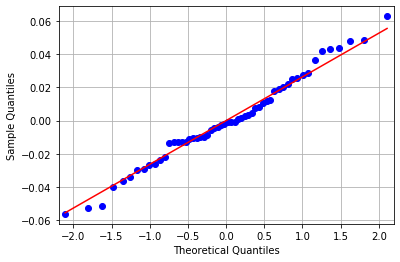

In [30]:
sm.qqplot(results.resid, line='s')
plt.grid()
plt.plot()
_, p = stats.shapiro(results.resid)
print('Shapiro-Wilk test p-value: {}'.format(p))

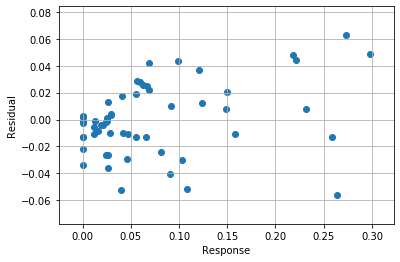

In [31]:
results.resid
plt.scatter(y_df, results.resid)
plt.xlabel('Response')
plt.ylabel('Residual')
plt.grid()
plt.show()